# Airbnb - Predicting the Listing Price

## Importing librares

In [1]:
# For Analysis
import numpy as np
import pandas as pd

# For Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# For Calculations
from math import floor

#For Feature Selection
from sklearn.feature_selection import RFE,RFECV
from sklearn.feature_selection import SelectFromModel
from boruta import BorutaPy
from sklearn.preprocessing import MinMaxScaler

#For Modeling
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict

from sklearn.linear_model import LogisticRegression, LinearRegression, LogisticRegressionCV, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import LinearSVC, SVR, SVC

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

from sklearn.naive_bayes import GaussianNB as gnb
from sklearn.naive_bayes import MultinomialNB as mnb
from sklearn.naive_bayes import BernoulliNB as bnb

# For Validation
from sklearn.metrics import mean_squared_error, accuracy_score, roc_curve, auc
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report

# For Storing Models
import pickle
%matplotlib inline

#Misc packages
from scipy import interp
from itertools import cycle

# For Gradient Boosting
import lightgbm as lgb

#For Timing
import time
from datetime import timedelta

import eli5

## Support Functions

##### Define a function to Show Culumns with missing values and their count

In [2]:
def show_cols_with_missing(df):
    missing_vals = df.isnull().sum().sort_values(ascending = False)
    
    return missing_vals.iloc[missing_vals.nonzero()[0]]

##### Define a function to build ROC curve for multiclass classification

In [3]:
def plot_roc(y_actual,y_calc,modname, n_classes = 3):
    t1=sum(x==0 for x in y_calc-y_actual)/len(y_calc)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(np.array(pd.get_dummies(y_actual))[:, i], np.array(pd.get_dummies(y_calc))[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    lw=2
    plt.figure(figsize=(8,8))
    plt.plot(fpr["macro"], tpr["macro"],
    label='macro-average ROC curve (area = {0:0.2f})'
          ''.format(roc_auc["macro"]),
    color='green', linestyle=':', linewidth=4)
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(str('Receiver Operating Characteristics for '+modname))
    plt.legend(loc="lower right")
    plt.show()

##### Relative Error

In [4]:
def weighted_classification_err(con_mat): 
    err = []
    labs = []
    for i in range(len(con_mat)):
        err.append((con_mat[i,:].sum() - con_mat[i,i])/(con_mat[i,:].sum()))
        labs.append(i)
    return pd.DataFrame(list(zip(labs,err)),columns=['Labels','Relative classification Error'])


##### MAPE

In [5]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

##### SMAPE

In [6]:
def symmetric_mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))


## Read in the preprocessed Dataframe

In [7]:
filename = '../data/saved/listings_dtypes.sav'
listings_dtypes = pickle.load(open(filename, 'rb'))

listings = pd.read_csv("../data/saved/preprocessed_listings.csv", dtype= listings_dtypes)

In [8]:
listings.shape

(73923, 108)

#### Filter in the Required Records


In [9]:
listings = listings[listings.price > 10]

In [10]:
listings = listings[listings.price <= 500]

In [13]:
listings = listings.drop('Unnamed: 0', axis = 1)

### Data Visualization

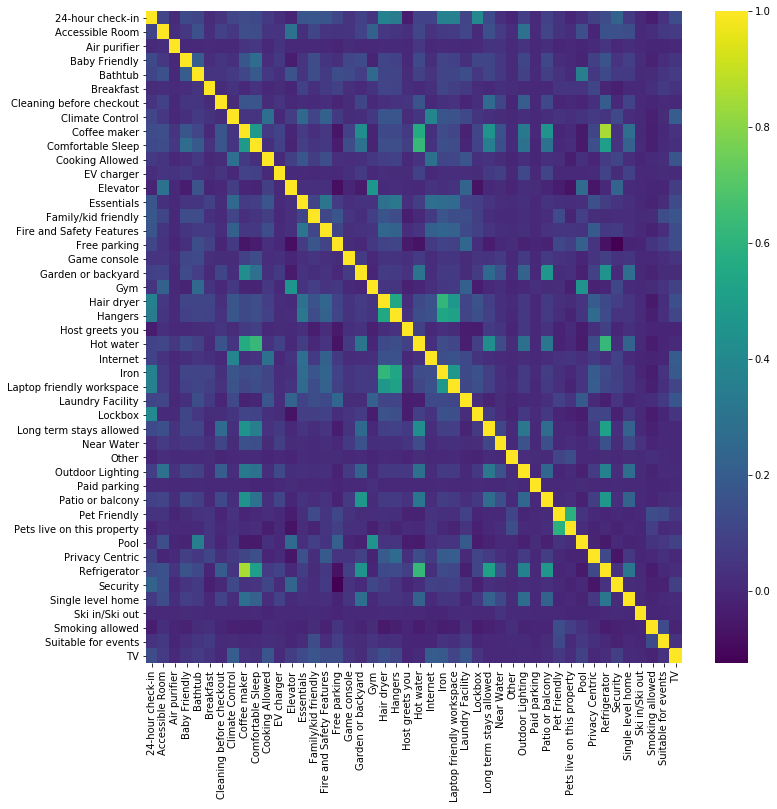

In [14]:
## Generating the heatmap for visualization - using Seaborn
listings_selected_amenities = listings[['24-hour check-in', 'Accessible Room', 'Air purifier',
       'Baby Friendly', 'Bathtub', 'Breakfast', 'Cleaning before checkout',
       'Climate Control', 'Coffee maker', 'Comfortable Sleep',
       'Cooking Allowed', 'EV charger', 'Elevator', 'Essentials',
       'Family/kid friendly', 'Fire and Safety Features', 'Free parking',
       'Game console', 'Garden or backyard', 'Gym', 'Hair dryer', 'Hangers',
       'Host greets you', 'Hot water', 'Internet', 'Iron',
       'Laptop friendly workspace', 'Laundry Facility', 'Lockbox',
       'Long term stays allowed', 'Near Water', 'Other', 'Outdoor Lighting',
       'Paid parking', 'Patio or balcony', 'Pet Friendly',
       'Pets live on this property', 'Pool', 'Privacy Centric', 'Refrigerator',
       'Security', 'Single level home', 'Ski in/Ski out', 'Smoking allowed',
       'Suitable for events', 'TV']]
fig = plt.figure(figsize= (12,12))
sns.heatmap(listings_selected_amenities.corr(), annot=False, vmax=1, cmap='viridis', square=False)

### Visualization of target variables

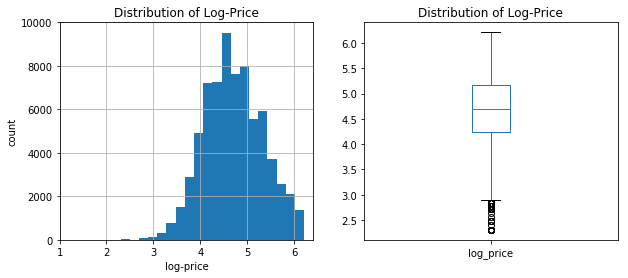

In [15]:
# The Log Price column
fig = plt.figure(figsize = (10,4))

ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

listings.log_price.hist(ax = ax1, bins = 20)
ax1.set_title('Distribution of Log-Price')
ax1.set_xlabel('log-price')
ax1.set_ylabel('count')
ax1.set_xticks(range(1,7,1))

# The Log Price column
plot = listings.log_price.plot(kind = 'box', ax = ax2)
ax2.set_title('Distribution of Log-Price')

plt.show()

In [16]:
def process_log_price(df):
    
    cut_points = [-1,4,4.5,5.5,10]
    label_names = [1,2,3,4]
    df["log_price_categories"] = pd.cut(df["log_price"],cut_points,labels=label_names)
    return df

In [17]:
listings = process_log_price(listings)

In [18]:
show_cols_with_missing(listings)

host_response_rate      17195
review_scores_rating    15418
zipcode                   558
amenities                 546
dtype: int64

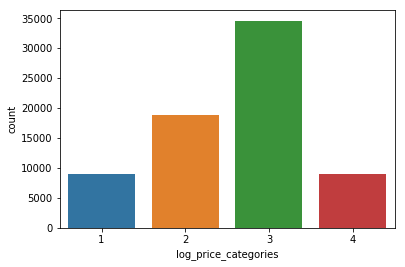

In [19]:
# Visualize the Split
sns.countplot(listings['log_price_categories'])

In [20]:
listings.log_price_categories.value_counts()

3    34582
2    18856
4     9056
1     8974
Name: log_price_categories, dtype: int64

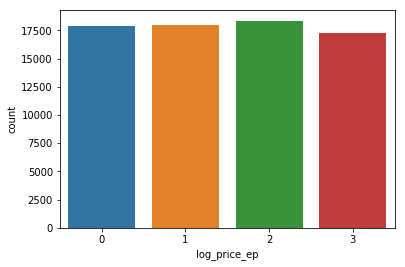

In [21]:
# Create equal probability bins at the PENTILES of RATING
listings = listings.assign(
    log_price_ep = pd.qcut(
        listings['log_price'],
        q=4,
        duplicates='drop',
        #labels=['below_93', '93_to_98', '99_to_100']
        labels=[0,1,2,3]
    )
)

# Visualize the Split
fig = plt.Figure(figsize=(10,10))
sns.countplot(listings['log_price_ep'])

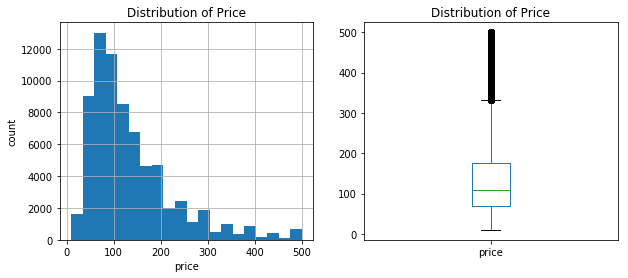

In [22]:
# The Price column
fig = plt.figure(figsize = (10,4))

ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

listings.price.hist(ax = ax1, bins = 20)
ax1.set_title('Distribution of Price')
ax1.set_xlabel('price')
ax1.set_ylabel('count')

# The Log Price column
plot = listings.price.plot(kind = 'box', ax = ax2)
ax2.set_title('Distribution of Price')

plt.show()

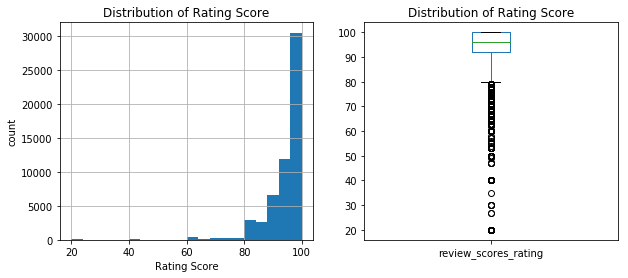

In [23]:
# The Log Price column
fig = plt.figure(figsize = (10,4))

ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

listings.review_scores_rating.hist(ax = ax1, bins = 20)
ax1.set_title('Distribution of Rating Score')
ax1.set_xlabel('Rating Score')
ax1.set_ylabel('count')

# The Log Price column
plot = listings.review_scores_rating.plot(kind = 'box', ax = ax2)
ax2.set_title('Distribution of Rating Score')

plt.show()

## Modelling - Listing Price

In [24]:
list(listings)

['id',
 'log_price',
 'property_type',
 'room_type',
 'amenities',
 'accommodates',
 'bathrooms',
 'bed_type',
 'cancellation_policy',
 'cleaning_fee',
 'city',
 'host_has_profile_pic',
 'host_identity_verified',
 'host_response_rate',
 'instant_bookable',
 'latitude',
 'longitude',
 'name',
 'Neighbourhood',
 'number_of_reviews',
 'review_scores_rating',
 'thumbnail_url',
 'zipcode',
 'bedrooms',
 'beds',
 'dist_to_attr1',
 'dist_to_attr2',
 'dist_to_attr3',
 'dist_to_station',
 'year_of_listing',
 'month_of_listing',
 'days_since_hosted',
 'price',
 'bedroom_share',
 'bathroom_share',
 'room_type_Entire home/apt',
 'room_type_Private room',
 'room_type_Shared room',
 'city_Boston',
 'city_Chicago',
 'city_DC',
 'city_LA',
 'city_NYC',
 'city_SF',
 'property_type_Apartment',
 'property_type_Condominium',
 'property_type_House',
 'property_type_Loft',
 'property_type_Townhouse',
 'property_type_other_prop_type',
 'bed_type_Real Bed',
 'bed_type_other_bed_type',
 'cancellation_policy_fl

In [25]:
np.random.seed(2018)
train = np.random.choice([True, False], listings.shape[0], replace=True, p=[0.8, 0.2])
listings_train = listings.iloc[train,:]
listings_test = listings.iloc[~train,:]


### Linear Regression


#### Linear Regression Model - Basic


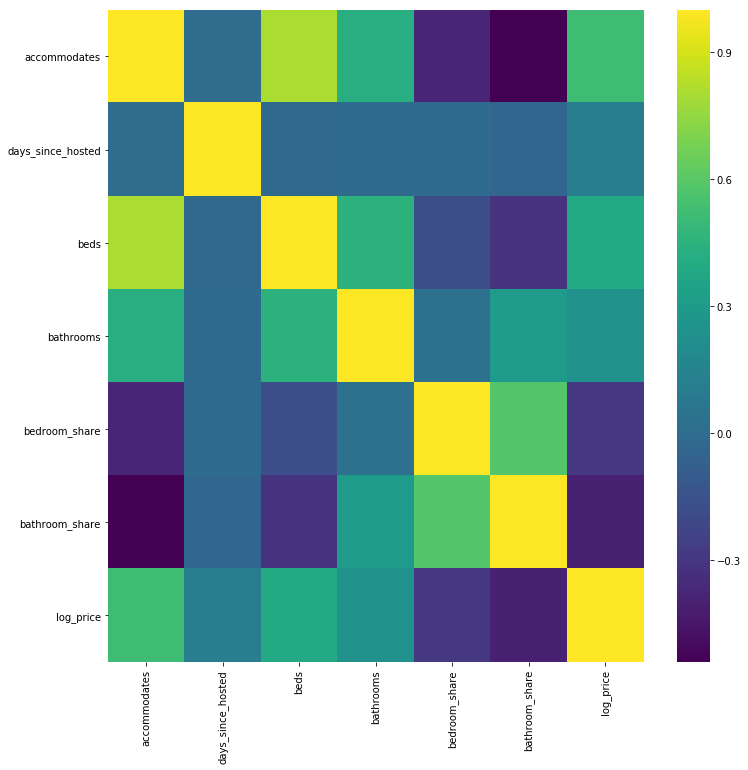

In [26]:
## Generating the heatmap for visualization - using Seaborn
listings_selected_amenities = listings[[
    'accommodates', 
    'days_since_hosted',
    'beds','bathrooms',
    'bedroom_share','bathroom_share',
    'log_price'
]]
fig = plt.figure(figsize= (12,12))
sns.heatmap(listings_selected_amenities.corr(), annot=False, vmax=1, cmap='viridis', square=False)

In [27]:
train_cols = [
    'accommodates', 
    'days_since_hosted',
    'beds','bathrooms',
    'cleaning_fee',
    'city_Boston', 'city_Chicago', 'city_DC','city_LA', 'city_NYC',
    'room_type_Entire home/apt', 'room_type_Private room',
    'property_type_Apartment','property_type_House', 
    'cancellation_policy_flexible', 'cancellation_policy_moderate','instant_bookable'
]

target_col = 'log_price'
removed_cols = [
    
    'id', 'price', 'property_type', 'room_type', 'amenities', 'bed_type', 'cancellation_policy',
    'city', 'first_review', 'year_of_listing', 'last_review', 'latitude', 'longitude', 'name',
    'Neighbourhood', 'thumbnail_url', 'zipcode',

    'description_length', 
    'days_since_hosted',
     
    
    '24-hour check-in', 'Bathtub',
    'Breakfast', 'Cooking Allowed', 'Elevator', 'Essentials',
    'Family/kid friendly', 'Fire and Safety Features', 'Free parking',
    'Gym', 'Hair dryer', 'Hangers', 'Internet', 'Iron',
    'Laptop friendly workspace', 'Laundry Facility', 'Lockbox',
    'Pet Friendly', 'Pets live on this property', 'Pool', 'Privacy Centric',
    'Security', 'Smoking allowed', 'Suitable for events', 'TV',
    
    'bedroom_share','bathroom_share'
    
    'bed_type_Real Bed',
    'dist_to_attr1','dist_to_attr2', 'dist_to_attr3', 
    'dist_to_station',
    
    'month_of_listing','host_identity_verified', 'host_response_rate', 'host_since',  
    'days_since_hosted',  
    'bed_type_other_bed_type',
    'property_type_other_prop_type',
    'room_type_Shared room',
    'cancellation_policy_strict', 
    'host_has_profile_pic', 
    'number_of_reviews','review_scores_rating'
]
x_train = listings_train[train_cols].values
x_test = listings_test[train_cols].values
y_train = listings_train[target_col].values
y_test = listings_test[target_col].values

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(57191, 17) (14277, 17) (57191,) (14277,)


In [28]:
#Min Max Scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

C:\Users\Manu\Anaconda3\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [29]:
# Declare an instance of the Linear Regression model.
lm = LinearRegression()

# Fit the model on to the training data( Train the model ).
lm.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [30]:
# Use the model to predict values
y_pred = lm.predict(x_train)

# Calculate the Mean Squared Error using the mean_squared_error function.
print("Training Data")
print("R^2 value using score fn: %.3f" % lm.score(x_train,y_train))
print("Mean Squared Log Error : %0.3f" % mean_squared_error(y_train,y_pred))
print("Mean Squared Error : %0.3f" % mean_squared_error(np.exp(y_train),np.exp(y_pred)))
print("Root Mean Squared Error : %0.3f" % mean_squared_error(np.exp(y_train),np.exp(y_pred))**0.5)
print("SMAPE : %0.3f " % symmetric_mean_absolute_percentage_error(np.exp(y_train),np.exp(y_pred)))

Training Data
R^2 value using score fn: 0.522
Mean Squared Log Error : 0.190
Mean Squared Error : 4864.294
Root Mean Squared Error : 69.744
SMAPE : 32.773 


In [31]:
# Use the model to predict values
y_pred = lm.predict(x_test)

# Calculate the Mean Squared Error using the mean_squared_error function.
print("Test Data")
print("R^2 value using score fn: %.3f" % lm.score(x_test,y_test))
print("Mean Squared Log Error : %0.3f" % mean_squared_error(y_test,y_pred))
print("Mean Squared Error : %0.3f" % mean_squared_error(np.exp(y_test),np.exp(y_pred)))
print("Root Mean Squared Error : %0.3f" % mean_squared_error(np.exp(y_test),np.exp(y_pred))**0.5)
print("SMAPE : %0.3f " % symmetric_mean_absolute_percentage_error(np.exp(y_test),np.exp(y_pred)))

Test Data
R^2 value using score fn: 0.523
Mean Squared Log Error : 0.189
Mean Squared Error : 4728.834
Root Mean Squared Error : 68.767
SMAPE : 32.858 


In [32]:
print(lm.intercept_, lm.coef_)

3.999607267731207 [ 1.4295709   0.15483889 -0.28920394  0.93252875 -0.01492774 -0.25206757
 -0.5482375  -0.32767346 -0.42100845 -0.29300431  1.04672644  0.4607012
 -0.05789375 -0.07550228  0.01755653 -0.03133654 -0.05397556]


In [33]:
lin_reg_coef = pd.DataFrame(list(zip(train_cols,(lm.coef_))),columns=['Feature','Coefficient'])
lin_reg_coef.sort_values(by='Coefficient',ascending=False)


,Feature,Coefficient
0,accommodates,1.429571
10,room_type_Entire home/apt,1.046726
3,bathrooms,0.932529
11,room_type_Private room,0.460701
1,days_since_hosted,0.154839
14,cancellation_policy_flexible,0.017557
4,cleaning_fee,-0.014928
15,cancellation_policy_moderate,-0.031337
16,instant_bookable,-0.053976
12,property_type_Apartment,-0.057894


C:\Users\Manu\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'Residuals for the model')

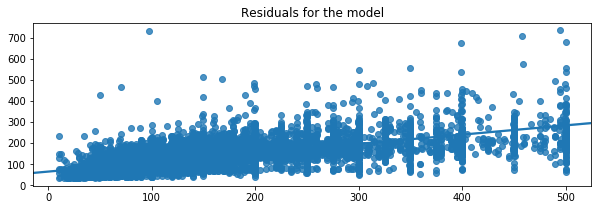

In [34]:
# Plot of Casual and Registered model's residuals:
fig = plt.figure(figsize=(10,3))

sns.regplot(np.exp(y_test),np.exp(y_pred))
plt.title("Residuals for the model")


#### Linear Regression Model - Basic + Amenities


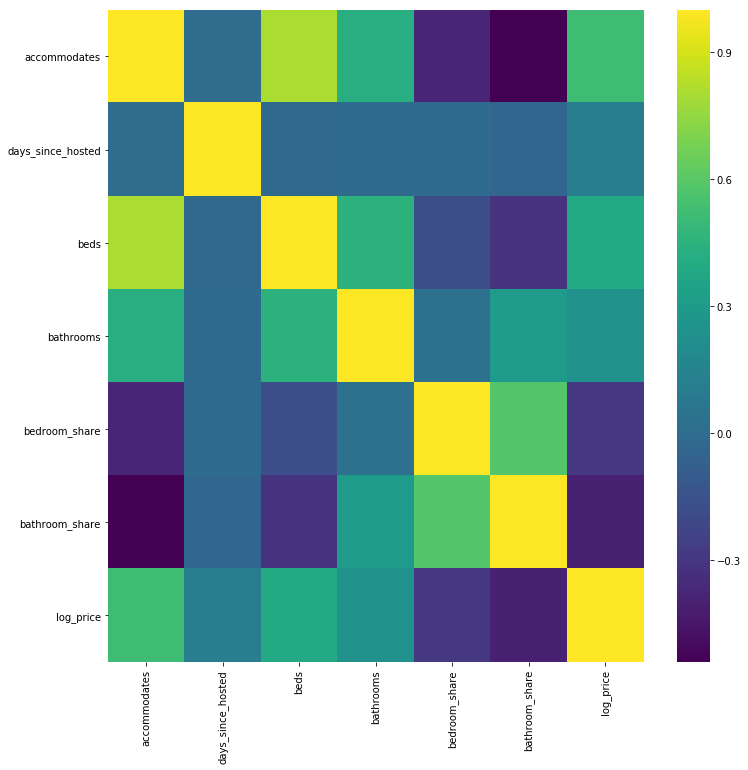

In [35]:
## Generating the heatmap for visualization - using Seaborn
listings_selected_amenities = listings[[
    'accommodates', 
    'days_since_hosted',
    'beds','bathrooms',
    'bedroom_share','bathroom_share',
    'log_price'
]]
fig = plt.figure(figsize= (12,12))
sns.heatmap(listings_selected_amenities.corr(), annot=False, vmax=1, cmap='viridis', square=False)

In [36]:
train_cols = [
    'accommodates', 
    'days_since_hosted',
    'beds','bathrooms',
    'cleaning_fee',
    'city_Boston', 'city_Chicago', 'city_DC','city_LA', 'city_NYC',
    'room_type_Entire home/apt', 'room_type_Private room',
    'property_type_Apartment','property_type_House', 
    'cancellation_policy_flexible', 'cancellation_policy_moderate','instant_bookable',
    
    # Amenities
    'id', '24-hour check-in', 'Accessible Room', 'Air purifier',
    'Baby Friendly', 'Bathtub', 'Breakfast', 'Cleaning before checkout',
    'Climate Control', 'Coffee maker', 'Comfortable Sleep',
    'Cooking Allowed', 'EV charger', 'Elevator', 'Essentials',
    'Family/kid friendly', 'Fire and Safety Features', 'Free parking',
    'Game console', 'Garden or backyard', 'Gym', 'Hair dryer', 'Hangers',
    'Host greets you', 'Hot water', 'Internet', 'Iron',
    'Laptop friendly workspace', 'Laundry Facility', 'Lockbox',
    'Long term stays allowed', 'Near Water', 'Other', 'Outdoor Lighting',
    'Paid parking', 'Patio or balcony', 'Pet Friendly',
    'Pets live on this property', 'Pool', 'Privacy Centric', 'Refrigerator',
    'Security', 'Single level home', 'Ski in/Ski out', 'Smoking allowed',
    'Suitable for events', 'TV'
]

target_col = 'log_price'
removed_cols = [
    
    'id', 'price', 'property_type', 'room_type', 'amenities', 'bed_type', 'cancellation_policy',
    'city', 'first_review', 'year_of_listing', 'last_review', 'latitude', 'longitude', 'name',
    'Neighbourhood', 'thumbnail_url', 'zipcode',

    'description_length', 
    'days_since_hosted',
     
    
    
    
    'bedroom_share','bathroom_share'
    
    'bed_type_Real Bed',
    'dist_to_attr1','dist_to_attr2', 'dist_to_attr3', 
    'dist_to_station',
    
    'month_of_listing','host_identity_verified', 'host_response_rate', 'host_since',  
    'days_since_hosted',  
    'bed_type_other_bed_type',
    'property_type_other_prop_type',
    'room_type_Shared room',
    'cancellation_policy_strict', 
    'host_has_profile_pic', 
    'number_of_reviews','review_scores_rating'
]
x_train = listings_train[train_cols].values
x_test = listings_test[train_cols].values
y_train = listings_train[target_col].values
y_test = listings_test[target_col].values

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(57191, 64) (14277, 64) (57191,) (14277,)


In [37]:
#Min Max Scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

C:\Users\Manu\Anaconda3\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [38]:
# Declare an instance of the Linear Regression model.
lm = LinearRegression()

# Fit the model on to the training data( Train the model ).
lm.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [39]:
# Use the model to predict values
y_pred = lm.predict(x_train)

# Calculate the Mean Squared Error using the mean_squared_error function.
print("Training Data")
print("R^2 value using score fn: %.3f" % lm.score(x_train,y_train))
print("Mean Squared Log Error : %0.3f" % mean_squared_error(y_train,y_pred))
print("Mean Squared Error : %0.3f" % mean_squared_error(np.exp(y_train),np.exp(y_pred)))
print("Root Mean Squared Error : %0.3f" % mean_squared_error(np.exp(y_train),np.exp(y_pred))**0.5)
print("SMAPE : %0.3f " % symmetric_mean_absolute_percentage_error(np.exp(y_train),np.exp(y_pred)))

Training Data
R^2 value using score fn: 0.549
Mean Squared Log Error : 0.179
Mean Squared Error : 4608.978
Root Mean Squared Error : 67.889
SMAPE : 31.765 


In [40]:
# Use the model to predict values
y_pred = lm.predict(x_test)

# Calculate the Mean Squared Error using the mean_squared_error function.
print("Test Data")
print("R^2 value using score fn: %.3f" % lm.score(x_test,y_test))
print("Mean Squared Log Error : %0.3f" % mean_squared_error(y_test,y_pred))
print("Mean Squared Error : %0.3f" % mean_squared_error(np.exp(y_test),np.exp(y_pred)))
print("Root Mean Squared Error : %0.3f" % mean_squared_error(np.exp(y_test),np.exp(y_pred))**0.5)
print("SMAPE : %0.3f " % symmetric_mean_absolute_percentage_error(np.exp(y_test),np.exp(y_pred)))

Test Data
R^2 value using score fn: 0.550
Mean Squared Log Error : 0.179
Mean Squared Error : 4475.783
Root Mean Squared Error : 66.901
SMAPE : 31.913 


In [41]:
print(lm.intercept_, lm.coef_)

4.0046160451197785 [ 1.33426684e+00  1.48038817e-01 -2.35519894e-01  8.22830856e-01
 -1.43207129e-02 -2.56749584e-01 -5.63922513e-01 -3.47037741e-01
 -4.38185125e-01 -2.79061289e-01  1.01926619e+00  4.71027726e-01
 -7.04015661e-02 -3.62132000e-02  1.73678627e-02 -2.58344788e-02
 -4.58102543e-02 -3.74615531e-03 -3.85411335e-02 -1.26935614e-02
 -2.16110954e-01 -1.06426974e-02  6.12789241e-03  1.46610321e-02
  5.69538601e-02  1.43315131e-02  5.58848045e-02  1.89440776e-02
 -4.04102912e-02  6.12133597e-03  8.41344725e-02  4.60354560e-03
  2.83513378e-02 -2.59055167e-02 -2.20099431e-02  9.54170668e-03
 -7.51745906e-02  7.70282316e-02  5.44355553e-02 -2.46667880e-02
 -2.39040172e-02 -1.09980435e-02 -9.02533810e-02 -9.66321290e-03
 -1.09793267e-02  6.31037075e-02 -1.16778622e-02 -1.83038467e-02
 -7.73408171e-03 -2.66534557e-04 -1.66429912e-02 -1.89391863e-01
  6.53974662e-02  8.77196178e-03 -2.25865886e-02  2.33735052e-02
 -3.72295695e-02 -3.59689001e-02  4.33188472e-02 -2.17976882e-02
 -8.17

In [42]:
lin_reg_coef = pd.DataFrame(list(zip(train_cols,(lm.coef_))),columns=['Feature','Coefficient'])
lin_reg_coef.sort_values(by='Coefficient',ascending=False)


,Feature,Coefficient
0,accommodates,1.334267
10,room_type_Entire home/apt,1.019266
3,bathrooms,0.822831
11,room_type_Private room,0.471028
1,days_since_hosted,0.148039
63,TV,0.133649
30,Elevator,0.084134
37,Gym,0.077028
52,Patio or balcony,0.065397
45,Laundry Facility,0.063104


C:\Users\Manu\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'Residuals for the model')

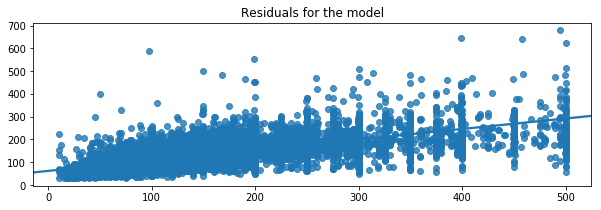

In [43]:
# Plot of Casual and Registered model's residuals:
fig = plt.figure(figsize=(10,3))

sns.regplot(np.exp(y_test),np.exp(y_pred))
plt.title("Residuals for the model")


#### Linear Regression Model - Basic + Amenities + Description


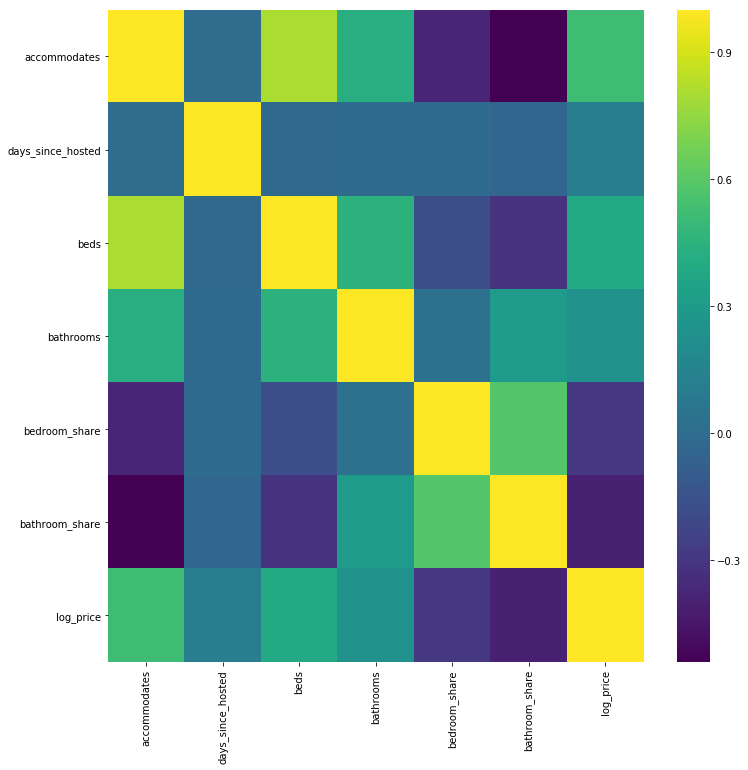

In [44]:
## Generating the heatmap for visualization - using Seaborn
listings_selected_amenities = listings[[
    'accommodates', 
    'days_since_hosted',
    'beds','bathrooms',
    'bedroom_share','bathroom_share',
    'log_price'
]]
fig = plt.figure(figsize= (12,12))
sns.heatmap(listings_selected_amenities.corr(), annot=False, vmax=1, cmap='viridis', square=False)

In [45]:
train_cols = [
    'accommodates', 
    'days_since_hosted',
    'beds','bathrooms',
    'cleaning_fee',
    'city_Boston', 'city_Chicago', 'city_DC','city_LA', 'city_NYC',
    'room_type_Entire home/apt', 'room_type_Private room',
    'property_type_Apartment','property_type_House', 
    'cancellation_policy_flexible', 'cancellation_policy_moderate','instant_bookable',
    
    # Amenities
    'id', '24-hour check-in', 'Accessible Room', 'Air purifier',
    'Baby Friendly', 'Bathtub', 'Breakfast', 'Cleaning before checkout',
    'Climate Control', 'Coffee maker', 'Comfortable Sleep',
    'Cooking Allowed', 'EV charger', 'Elevator', 'Essentials',
    'Family/kid friendly', 'Fire and Safety Features', 'Free parking',
    'Game console', 'Garden or backyard', 'Gym', 'Hair dryer', 'Hangers',
    'Host greets you', 'Hot water', 'Internet', 'Iron',
    'Laptop friendly workspace', 'Laundry Facility', 'Lockbox',
    'Long term stays allowed', 'Near Water', 'Other', 'Outdoor Lighting',
    'Paid parking', 'Patio or balcony', 'Pet Friendly',
    'Pets live on this property', 'Pool', 'Privacy Centric', 'Refrigerator',
    'Security', 'Single level home', 'Ski in/Ski out', 'Smoking allowed',
    'Suitable for events', 'TV',
    
    #Description
    'description_length','sentiment_intensity', 'lda_attractions', 
    'lda_transport', 'lda_amenities', 'lda_property_desc'
]

target_col = 'log_price'
removed_cols = [
    
    'id', 'price', 'property_type', 'room_type', 'amenities', 'bed_type', 'cancellation_policy',
    'city', 'first_review', 'year_of_listing', 'last_review', 'latitude', 'longitude', 'name',
    'Neighbourhood', 'thumbnail_url', 'zipcode',

    'days_since_hosted',
     
    'bedroom_share','bathroom_share'
    
    'bed_type_Real Bed',
    'dist_to_attr1','dist_to_attr2', 'dist_to_attr3', 
    'dist_to_station',
    
    'month_of_listing','host_identity_verified', 'host_response_rate', 'host_since',  
    'days_since_hosted',  
    'bed_type_other_bed_type',
    'property_type_other_prop_type',
    'room_type_Shared room',
    'cancellation_policy_strict', 
    'host_has_profile_pic', 
    'number_of_reviews','review_scores_rating'
]
x_train = listings_train[train_cols].values
x_test = listings_test[train_cols].values
y_train = listings_train[target_col].values
y_test = listings_test[target_col].values

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(57191, 70) (14277, 70) (57191,) (14277,)


In [46]:
#Min Max Scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

C:\Users\Manu\Anaconda3\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [47]:
# Declare an instance of the Linear Regression model.
lm = LinearRegression()

# Fit the model on to the training data( Train the model ).
lm.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [48]:
# Use the model to predict values
y_pred = lm.predict(x_train)

# Calculate the Mean Squared Error using the mean_squared_error function.
print("Training Data")
print("R^2 value using score fn: %.3f" % lm.score(x_train,y_train))
print("Mean Squared Log Error : %0.3f" % mean_squared_error(y_train,y_pred))
print("Mean Squared Error : %0.3f" % mean_squared_error(np.exp(y_train),np.exp(y_pred)))
print("Root Mean Squared Error : %0.3f" % mean_squared_error(np.exp(y_train),np.exp(y_pred))**0.5)
print("SMAPE : %0.3f " % symmetric_mean_absolute_percentage_error(np.exp(y_train),np.exp(y_pred)))

Training Data
R^2 value using score fn: 0.572
Mean Squared Log Error : 0.170
Mean Squared Error : 4416.823
Root Mean Squared Error : 66.459
SMAPE : 30.953 


In [49]:
# Use the model to predict values
y_pred = lm.predict(x_test)

# Calculate the Mean Squared Error using the mean_squared_error function.
print("Test Data")
print("R^2 value using score fn: %.3f" % lm.score(x_test,y_test))
print("Mean Squared Log Error : %0.3f" % mean_squared_error(y_test,y_pred))
print("Mean Squared Error : %0.3f" % mean_squared_error(np.exp(y_test),np.exp(y_pred)))
print("Root Mean Squared Error : %0.3f" % mean_squared_error(np.exp(y_test),np.exp(y_pred))**0.5)
print("SMAPE : %0.3f " % symmetric_mean_absolute_percentage_error(np.exp(y_test),np.exp(y_pred)))

Test Data
R^2 value using score fn: 0.573
Mean Squared Log Error : 0.170
Mean Squared Error : 4281.893
Root Mean Squared Error : 65.436
SMAPE : 31.080 


In [50]:
print(lm.intercept_, lm.coef_)

3.8128916207863623 [ 1.29477486  0.15103799 -0.20421766  0.6970603  -0.02043457 -0.1919898
 -0.48313961 -0.23227471 -0.35967848 -0.1321731   0.93885591  0.43167683
 -0.06128671 -0.02937012  0.01505271 -0.02125155 -0.04311312 -0.00480912
 -0.03657496 -0.01085189 -0.19850233 -0.01634031  0.00217607  0.02420552
  0.06318179  0.01410523  0.04931107  0.0253845  -0.04393945  0.0137439
  0.07067721  0.00825738  0.02475746 -0.01819875 -0.01979631  0.00961336
 -0.06424029  0.05360766  0.05523683 -0.02871814 -0.01931282 -0.01296277
 -0.08539839 -0.01122852 -0.0085578   0.0474581  -0.00611797 -0.02723143
 -0.00920626  0.01715377 -0.01217264 -0.09653479  0.04174568  0.00421596
 -0.00512049  0.01215902 -0.03484765 -0.02653739  0.03654408 -0.02191924
 -0.16317469 -0.03519837  0.03983079  0.10927737 -0.01371974  0.07200382
  0.26877025  0.10932858 -0.09168231  0.47202494]


In [51]:
lin_reg_coef = pd.DataFrame(list(zip(train_cols,(lm.coef_))),columns=['Feature','Coefficient'])
lin_reg_coef.sort_values(by='Coefficient',ascending=False)


,Feature,Coefficient
0,accommodates,1.294775
10,room_type_Entire home/apt,0.938856
3,bathrooms,0.697060
69,lda_property_desc,0.472025
11,room_type_Private room,0.431677
66,lda_attractions,0.268770
1,days_since_hosted,0.151038
67,lda_transport,0.109329
63,TV,0.109277
65,sentiment_intensity,0.072004


C:\Users\Manu\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'Residuals for the model')

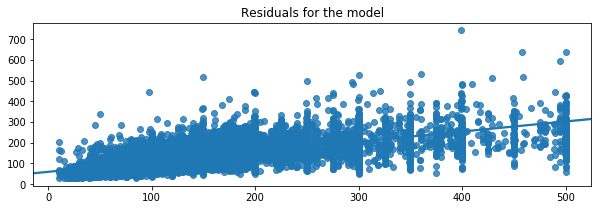

In [52]:
# Plot of Casual and Registered model's residuals:
fig = plt.figure(figsize=(10,3))

sns.regplot(np.exp(y_test),np.exp(y_pred))
plt.title("Residuals for the model")


#### Linear Regression Model - Basic + Amenities + Description + Distances


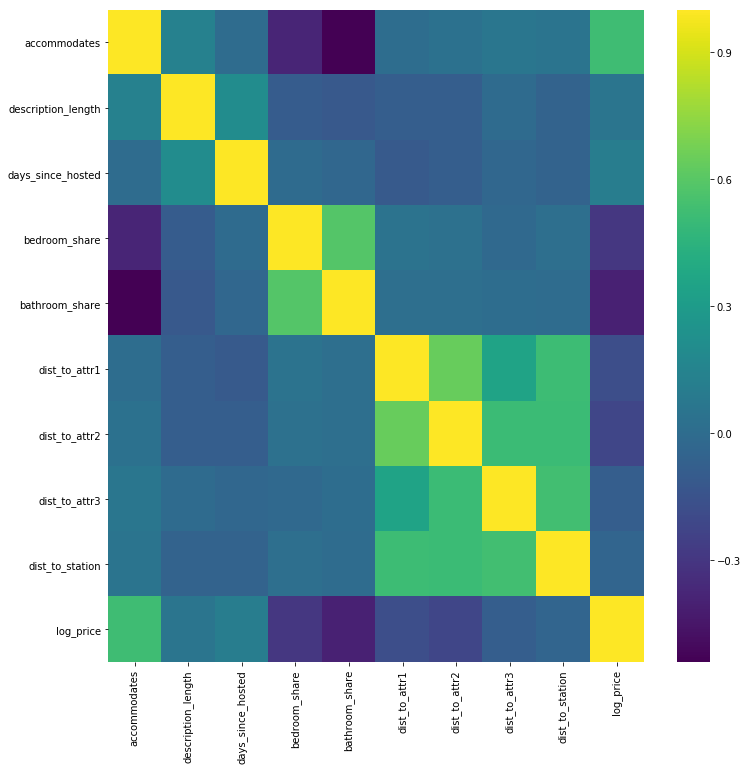

In [53]:
## Generating the heatmap for visualization - using Seaborn
listings_selected_amenities = listings[[
    'accommodates', 
    'description_length', 
    'days_since_hosted',
    'bedroom_share','bathroom_share',
    'dist_to_attr1','dist_to_attr2', 'dist_to_attr3', 
    'dist_to_station',
    'log_price'
]]
fig = plt.figure(figsize= (12,12))
sns.heatmap(listings_selected_amenities.corr(), annot=False, vmax=1, cmap='viridis', square=False)

In [54]:
train_cols = [
    'accommodates', 
    'days_since_hosted',
    'beds','bathrooms',
    'cleaning_fee',
    'city_Boston', 'city_Chicago', 'city_DC','city_LA', 'city_NYC',
    'room_type_Entire home/apt', 'room_type_Private room',
    'property_type_Apartment','property_type_House', 
    'cancellation_policy_flexible', 'cancellation_policy_moderate','instant_bookable',
    
    # Amenities
    'id', '24-hour check-in', 'Accessible Room', 'Air purifier',
    'Baby Friendly', 'Bathtub', 'Breakfast', 'Cleaning before checkout',
    'Climate Control', 'Coffee maker', 'Comfortable Sleep',
    'Cooking Allowed', 'EV charger', 'Elevator', 'Essentials',
    'Family/kid friendly', 'Fire and Safety Features', 'Free parking',
    'Game console', 'Garden or backyard', 'Gym', 'Hair dryer', 'Hangers',
    'Host greets you', 'Hot water', 'Internet', 'Iron',
    'Laptop friendly workspace', 'Laundry Facility', 'Lockbox',
    'Long term stays allowed', 'Near Water', 'Other', 'Outdoor Lighting',
    'Paid parking', 'Patio or balcony', 'Pet Friendly',
    'Pets live on this property', 'Pool', 'Privacy Centric', 'Refrigerator',
    'Security', 'Single level home', 'Ski in/Ski out', 'Smoking allowed',
    'Suitable for events', 'TV',
    
    #Description
    'description_length','sentiment_intensity', 'lda_attractions', 
    'lda_transport', 'lda_amenities', 'lda_property_desc',
    
    #Distances
    'dist_to_attr1','dist_to_attr2', 'dist_to_attr3', 
    'dist_to_station'
]

target_col = 'log_price'
removed_cols = [
    
    'id', 'price', 'property_type', 'room_type', 'amenities', 'bed_type', 'cancellation_policy',
    'city', 'first_review', 'year_of_listing', 'last_review', 'latitude', 'longitude', 'name',
    'Neighbourhood', 'thumbnail_url', 'zipcode',

    'days_since_hosted',
     
    'bedroom_share','bathroom_share'
    
    'bed_type_Real Bed',
    
    
    'month_of_listing','host_identity_verified', 'host_response_rate', 'host_since',  
    'days_since_hosted',  
    'bed_type_other_bed_type',
    'property_type_other_prop_type',
    'room_type_Shared room',
    'cancellation_policy_strict', 
    'host_has_profile_pic', 
    'number_of_reviews','review_scores_rating'
]
x_train = listings_train[train_cols].values
x_test = listings_test[train_cols].values
y_train = listings_train[target_col].values
y_test = listings_test[target_col].values

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(57191, 74) (14277, 74) (57191,) (14277,)


In [55]:
#Min Max Scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

C:\Users\Manu\Anaconda3\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [56]:
# Declare an instance of the Linear Regression model.
lm = LinearRegression()

# Fit the model on to the training data( Train the model ).
lm.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [57]:
# Use the model to predict values
y_pred = lm.predict(x_train)

# Calculate the Mean Squared Error using the mean_squared_error function.
print("Training Data")
print("R^2 value using score fn: %.3f" % lm.score(x_train,y_train))
print("Mean Squared Log Error : %0.3f" % mean_squared_error(y_train,y_pred))
print("Mean Squared Error : %0.3f" % mean_squared_error(np.exp(y_train),np.exp(y_pred)))
print("Root Mean Squared Error : %0.3f" % mean_squared_error(np.exp(y_train),np.exp(y_pred))**0.5)
print("SMAPE : %0.3f " % symmetric_mean_absolute_percentage_error(np.exp(y_train),np.exp(y_pred)))

Training Data
R^2 value using score fn: 0.602
Mean Squared Log Error : 0.158
Mean Squared Error : 4141.655
Root Mean Squared Error : 64.356
SMAPE : 29.501 


In [58]:
# Use the model to predict values
y_pred = lm.predict(x_test)

# Calculate the Mean Squared Error using the mean_squared_error function.
print("Test Data")
print("R^2 value using score fn: %.3f" % lm.score(x_test,y_test))
print("Mean Squared Log Error : %0.3f" % mean_squared_error(y_test,y_pred))
print("Mean Squared Error : %0.3f" % mean_squared_error(np.exp(y_test),np.exp(y_pred)))
print("Root Mean Squared Error : %0.3f" % mean_squared_error(np.exp(y_test),np.exp(y_pred))**0.5)
print("SMAPE : %0.3f " % symmetric_mean_absolute_percentage_error(np.exp(y_test),np.exp(y_pred)))

Test Data
R^2 value using score fn: 0.601
Mean Squared Log Error : 0.158
Mean Squared Error : 4020.543
Root Mean Squared Error : 63.408
SMAPE : 29.587 


In [59]:
print(lm.intercept_, lm.coef_)

4.10255262583974 [ 1.30379715e+00  1.18338630e-01 -1.44285762e-01  6.65832390e-01
 -2.24783264e-02 -2.44058715e-01 -4.50712210e-01 -2.85681514e-01
  3.04134508e-01 -5.57977071e-02  9.19272171e-01  4.28399097e-01
 -8.40258310e-02 -1.67342181e-03  2.49801465e-02 -9.40129350e-03
 -4.23809521e-02 -3.57256950e-03 -3.53637636e-02 -4.37980299e-03
 -1.30271607e-01 -1.49679812e-02  7.88057492e-03  3.25303532e-02
  7.66057649e-02  1.68722298e-02  4.23600739e-02  2.14614100e-02
 -4.66693491e-02 -4.51114025e-02  5.12494189e-02  4.30016636e-03
  3.62026261e-02 -1.23803805e-02  1.04457825e-02  9.08428317e-03
 -3.59482631e-02  4.85405482e-02  4.28565082e-02 -2.46363979e-02
 -6.05156136e-03 -9.73626561e-03 -1.10419876e-01 -5.63169813e-03
 -1.02676619e-02  4.47117531e-02 -7.90974089e-03 -2.65059039e-02
  8.30772382e-03  2.24779260e-02 -2.53580635e-03 -7.35991510e-02
  3.65245842e-02 -1.17191346e-03  7.11895626e-03  3.48357931e-02
 -2.86713190e-02 -1.97318961e-02  2.18200832e-02 -2.60011602e-02
 -1.8371

In [60]:
lin_reg_coef = pd.DataFrame(list(zip(train_cols,(lm.coef_))),columns=['Feature','Coefficient'])
lin_reg_coef.sort_values(by='Coefficient',ascending=False)


,Feature,Coefficient
73,dist_to_station,1.523692
0,accommodates,1.303797
10,room_type_Entire home/apt,0.919272
3,bathrooms,0.665832
11,room_type_Private room,0.428399
69,lda_property_desc,0.385392
8,city_LA,0.304135
66,lda_attractions,0.172468
1,days_since_hosted,0.118339
63,TV,0.105161


C:\Users\Manu\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'Residuals for the model')

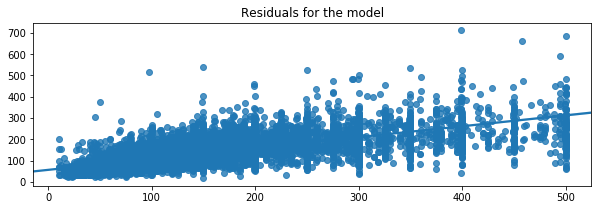

In [61]:
# Plot of Casual and Registered model's residuals:
fig = plt.figure(figsize=(10,3))

sns.regplot(np.exp(y_test),np.exp(y_pred))
plt.title("Residuals for the model")


### Regularization - Lasso

**Regularized cost function**

In [62]:
# Function to calculate regularized cost given alpha, mse and the model coefficients
def reg_cost(alpha, mse, coeffs, model = None):
    if model == "lasso":
        return mse + alpha * np.sum(np.abs(coeffs))
    elif model == "ridge":
        return mse + alpha * np.linalg.norm(coeffs)
    else:
        return mse

In [63]:
alpha_levels = [0.01, 0.1, 1, 10, 100]

for alpha_level in alpha_levels:
    print("\n At alpha Level: %0.2f "% alpha_level)

    lasso_lm = Lasso(alpha= alpha_level)

    # Fit the model on to the training data( Train the model ).
    lasso_lm.fit(x_train, y_train)

    # Use the model to predict values
    #y_pred = np.expm1(lm.predict(x_test))
    y_pred = lasso_lm.predict(x_test)

    # Calculate the Mean Squared Error using the mean_squared_error function.
    print("Test Data")
    print("R^2 value using score fn: %.3f" % lasso_lm.score(x_test,y_test))
    print("Mean Squared Log Error : %0.3f" % mean_squared_error(y_test,y_pred))
    print("Mean Squared Error : %0.3f" % mean_squared_error(np.exp(y_test),np.exp(y_pred)))
    print("Root Mean Squared Error : %0.3f" % mean_squared_error(np.exp(y_test),np.exp(y_pred))**0.5)
    print("SMAPE : %0.3f " % symmetric_mean_absolute_percentage_error(np.exp(y_test),np.exp(y_pred)))
    
    # Get model complexity using the user defined fn
    print("Model Complexity: %0.3f" % reg_cost(mse = 0, alpha = 1, coeffs= lasso_lm.coef_, model= "lasso"))
    
    # Get Regularized Cost using the user defined fn
    print("Regularized Cost: %0.3f" % reg_cost(mse = mean_squared_error(y_test,y_pred), alpha = alpha_level, coeffs= lasso_lm.coef_, model= "lasso"))


 At alpha Level: 0.01 
Test Data
R^2 value using score fn: 0.503
Mean Squared Log Error : 0.197
Mean Squared Error : 5152.791
Root Mean Squared Error : 71.783
SMAPE : 33.691 
Model Complexity: 1.979
Regularized Cost: 0.217

 At alpha Level: 0.10 
Test Data
R^2 value using score fn: 0.291
Mean Squared Log Error : 0.282
Mean Squared Error : 7244.355
Root Mean Squared Error : 85.114
SMAPE : 40.314 
Model Complexity: 0.390
Regularized Cost: 0.321

 At alpha Level: 1.00 
Test Data
R^2 value using score fn: -0.000
Mean Squared Log Error : 0.398
Mean Squared Error : 8995.932
Root Mean Squared Error : 94.847
SMAPE : 48.422 
Model Complexity: 0.000
Regularized Cost: 0.398

 At alpha Level: 10.00 
Test Data
R^2 value using score fn: -0.000
Mean Squared Log Error : 0.398
Mean Squared Error : 8995.932
Root Mean Squared Error : 94.847
SMAPE : 48.422 
Model Complexity: 0.000
Regularized Cost: 0.398

 At alpha Level: 100.00 
Test Data
R^2 value using score fn: -0.000
Mean Squared Log Error : 0.398
M

### Random Forest Regressor

#### Log Price

(57191, 82) (14277, 82) (57191,) (14277,)


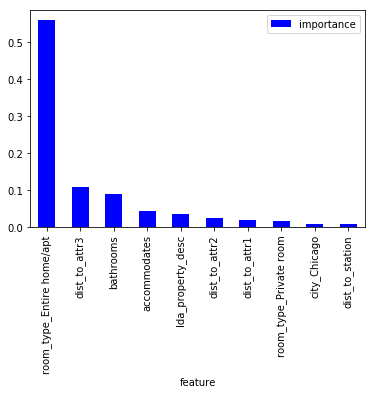

In [64]:
train_cols = [
    'accommodates', 
    'days_since_hosted',
    'beds','bathrooms',
    'cleaning_fee',
    'city_Boston', 'city_Chicago', 'city_DC','city_LA', 'city_NYC',
    'room_type_Entire home/apt', 'room_type_Private room',
    'property_type_Apartment','property_type_House', 
    'cancellation_policy_flexible', 'cancellation_policy_moderate','instant_bookable',
    
    # Amenities
    'id', '24-hour check-in', 'Accessible Room', 'Air purifier',
    'Baby Friendly', 'Bathtub', 'Breakfast', 'Cleaning before checkout',
    'Climate Control', 'Coffee maker', 'Comfortable Sleep',
    'Cooking Allowed', 'EV charger', 'Elevator', 'Essentials',
    'Family/kid friendly', 'Fire and Safety Features', 'Free parking',
    'Game console', 'Garden or backyard', 'Gym', 'Hair dryer', 'Hangers',
    'Host greets you', 'Hot water', 'Internet', 'Iron',
    'Laptop friendly workspace', 'Laundry Facility', 'Lockbox',
    'Long term stays allowed', 'Near Water', 'Other', 'Outdoor Lighting',
    'Paid parking', 'Patio or balcony', 'Pet Friendly',
    'Pets live on this property', 'Pool', 'Privacy Centric', 'Refrigerator',
    'Security', 'Single level home', 'Ski in/Ski out', 'Smoking allowed',
    'Suitable for events', 'TV',
    
    #Description
    'description_length','sentiment_intensity', 'lda_attractions', 
    'lda_transport', 'lda_amenities', 'lda_property_desc',
    
    #Distances
    'dist_to_attr1','dist_to_attr2', 'dist_to_attr3', 
    'dist_to_station',
    
    #Previously Excluded
    'bed_type_Real Bed',
    'host_identity_verified',  
    'days_since_hosted',  
    'bed_type_other_bed_type',
    'property_type_other_prop_type',
    'room_type_Shared room',
    'cancellation_policy_strict', 
    'host_has_profile_pic'
]

target_col = 'log_price'

x_train = listings_train[train_cols].values
x_test = listings_test[train_cols].values
y_train = listings_train[target_col].values
y_test = listings_test[target_col].values

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

#Create a random forest classifier
clf = RandomForestRegressor(max_depth=10, n_estimators=100)

#Train the classifier
clf.fit(x_train, y_train)

#Plot variable importances for the top 10 predictors
importances = clf.feature_importances_
feat_names = train_cols
tree_result = pd.DataFrame({'feature': feat_names, 'importance': importances})
tree_result.sort_values(by='importance',ascending=False)[:10].plot(x='feature', y='importance', kind='bar',color='blue')


In [65]:
# Use the model to predict values
y_pred = clf.predict(x_train)

# Calculate the Mean Squared Error using the mean_squared_error function.
print("Training Data")
print("R^2 value using score fn: %.3f" % clf.score(x_train,y_train))
print("Mean Squared Log Error : %0.3f" % mean_squared_error(y_train,y_pred))
print("Mean Squared Error : %0.3f" % mean_squared_error(np.exp(y_train),np.exp(y_pred)))
print("Root Mean Squared Error : %0.3f" % mean_squared_error(np.exp(y_train),np.exp(y_pred))**0.5)
print("SMAPE : %0.3f " % symmetric_mean_absolute_percentage_error(np.exp(y_train),np.exp(y_pred)))

Training Data
R^2 value using score fn: 0.711
Mean Squared Log Error : 0.115
Mean Squared Error : 3040.870
Root Mean Squared Error : 55.144
SMAPE : 25.383 


In [66]:
# Use the model to predict values
y_pred = clf.predict(x_test)

# Calculate the Mean Squared Error using the mean_squared_error function.
print("Test Data")
print("R^2 value using score fn: %.3f" % clf.score(x_test,y_test))
print("Mean Squared Log Error : %0.3f" % mean_squared_error(y_test,y_pred))
print("Mean Squared Error : %0.3f" % mean_squared_error(np.exp(y_test),np.exp(y_pred)))
print("Root Mean Squared Error : %0.3f" % mean_squared_error(np.exp(y_test),np.exp(y_pred))**0.5)
print("SMAPE : %0.3f " % symmetric_mean_absolute_percentage_error(np.exp(y_test),np.exp(y_pred)))

Test Data
R^2 value using score fn: 0.656
Mean Squared Log Error : 0.137
Mean Squared Error : 3540.710
Root Mean Squared Error : 59.504
SMAPE : 27.387 


C:\Users\Manu\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'Residuals for the model')

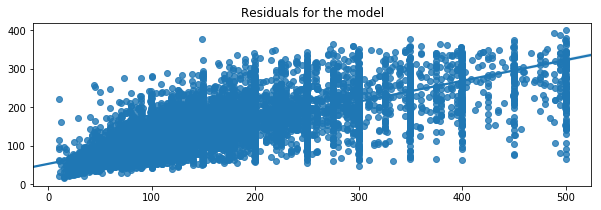

In [67]:
# Plot of Casual and Registered model's residuals:
fig = plt.figure(figsize=(10,3))

sns.regplot(np.exp(y_test),np.exp(y_pred))
plt.title("Residuals for the model")


#### Price

(57191, 82) (14277, 82) (57191,) (14277,)


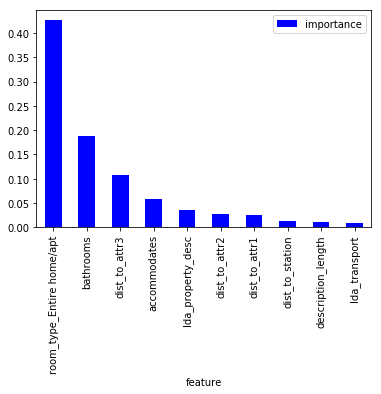

In [68]:
train_cols = [
    'accommodates', 
    'days_since_hosted',
    'beds','bathrooms',
    'cleaning_fee',
    'city_Boston', 'city_Chicago', 'city_DC','city_LA', 'city_NYC',
    'room_type_Entire home/apt', 'room_type_Private room',
    'property_type_Apartment','property_type_House', 
    'cancellation_policy_flexible', 'cancellation_policy_moderate','instant_bookable',
    
    # Amenities
    'id', '24-hour check-in', 'Accessible Room', 'Air purifier',
    'Baby Friendly', 'Bathtub', 'Breakfast', 'Cleaning before checkout',
    'Climate Control', 'Coffee maker', 'Comfortable Sleep',
    'Cooking Allowed', 'EV charger', 'Elevator', 'Essentials',
    'Family/kid friendly', 'Fire and Safety Features', 'Free parking',
    'Game console', 'Garden or backyard', 'Gym', 'Hair dryer', 'Hangers',
    'Host greets you', 'Hot water', 'Internet', 'Iron',
    'Laptop friendly workspace', 'Laundry Facility', 'Lockbox',
    'Long term stays allowed', 'Near Water', 'Other', 'Outdoor Lighting',
    'Paid parking', 'Patio or balcony', 'Pet Friendly',
    'Pets live on this property', 'Pool', 'Privacy Centric', 'Refrigerator',
    'Security', 'Single level home', 'Ski in/Ski out', 'Smoking allowed',
    'Suitable for events', 'TV',
    
    #Description
    'description_length','sentiment_intensity', 'lda_attractions', 
    'lda_transport', 'lda_amenities', 'lda_property_desc',
    
    #Distances
    'dist_to_attr1','dist_to_attr2', 'dist_to_attr3', 
    'dist_to_station',
    
    #Previously Excluded
    'bed_type_Real Bed',
    'host_identity_verified',  
    'days_since_hosted',  
    'bed_type_other_bed_type',
    'property_type_other_prop_type',
    'room_type_Shared room',
    'cancellation_policy_strict', 
    'host_has_profile_pic'
]

target_col = 'price'

x_train = listings_train[train_cols].values
x_test = listings_test[train_cols].values
y_train = listings_train[target_col].values
y_test = listings_test[target_col].values

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

#Create a random forest classifier
clf = RandomForestRegressor(max_depth=10, n_estimators=100)

#Train the classifier
clf.fit(x_train, y_train)

#Plot variable importances for the top 10 predictors
importances = clf.feature_importances_
feat_names = train_cols
tree_result = pd.DataFrame({'feature': feat_names, 'importance': importances})
tree_result.sort_values(by='importance',ascending=False)[:10].plot(x='feature', y='importance', kind='bar',color='blue')


In [69]:
# Use the model to predict values
y_pred = clf.predict(x_train)

# Calculate the Mean Squared Error using the mean_squared_error function.
print("Training Data")
print("R^2 value using score fn: %.3f" % clf.score(x_train,y_train))
#print("Mean Squared Log Error : %0.3f" % mean_squared_error(y_train,y_pred))
print("Mean Squared Error : %0.3f" % mean_squared_error(y_train,y_pred))
print("Root Mean Squared Error : %0.3f" % mean_squared_error((y_train),(y_pred))**0.5)
print("SMAPE : %0.3f " % symmetric_mean_absolute_percentage_error((y_train),(y_pred)))

Training Data
R^2 value using score fn: 0.675
Mean Squared Error : 2750.322
Root Mean Squared Error : 52.444
SMAPE : 26.971 


In [70]:
# Use the model to predict values
y_pred = clf.predict(x_test)

# Calculate the Mean Squared Error using the mean_squared_error function.
print("Test Data")
print("R^2 value using score fn: %.3f" % clf.score(x_test,y_test))
#print("Mean Squared Log Error : %0.3f" % mean_squared_error(y_test,y_pred))
print("Mean Squared Error : %0.3f" % mean_squared_error((y_test),(y_pred)))
print("Root Mean Squared Error : %0.3f" % mean_squared_error((y_test),(y_pred))**0.5)
print("SMAPE : %0.3f " % symmetric_mean_absolute_percentage_error((y_test),(y_pred)))

Test Data
R^2 value using score fn: 0.591
Mean Squared Error : 3439.819
Root Mean Squared Error : 58.650
SMAPE : 28.892 


C:\Users\Manu\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'Residuals for the model')

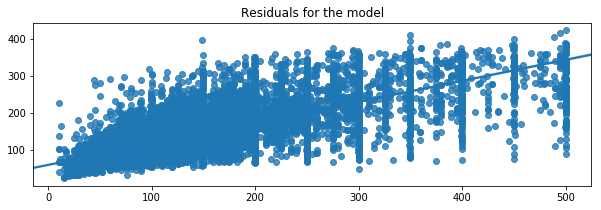

In [71]:
# Plot of Casual and Registered model's residuals:
fig = plt.figure(figsize=(10,3))

sns.regplot((y_test),(y_pred))
plt.title("Residuals for the model")


#### SVR

In [ ]:
#Select features to check their importance
feature_check_cols_svr = [
    'accommodates', 
    'days_since_hosted',
    'beds','bathrooms',
    'cleaning_fee',
    'city_Boston', 'city_Chicago', 'city_DC','city_LA', 'city_NYC',
    'room_type_Entire home/apt', 'room_type_Private room',
    'property_type_Apartment','property_type_House', 
    'cancellation_policy_flexible', 'cancellation_policy_moderate','instant_bookable',
    
    # Amenities
    'id', '24-hour check-in', 'Accessible Room', 'Air purifier',
    'Baby Friendly', 'Bathtub', 'Breakfast', 'Cleaning before checkout',
    'Climate Control', 'Coffee maker', 'Comfortable Sleep',
    'Cooking Allowed', 'EV charger', 'Elevator', 'Essentials',
    'Family/kid friendly', 'Fire and Safety Features', 'Free parking',
    'Game console', 'Garden or backyard', 'Gym', 'Hair dryer', 'Hangers',
    'Host greets you', 'Hot water', 'Internet', 'Iron',
    'Laptop friendly workspace', 'Laundry Facility', 'Lockbox',
    'Long term stays allowed', 'Near Water', 'Other', 'Outdoor Lighting',
    'Paid parking', 'Patio or balcony', 'Pet Friendly',
    'Pets live on this property', 'Pool', 'Privacy Centric', 'Refrigerator',
    'Security', 'Single level home', 'Ski in/Ski out', 'Smoking allowed',
    'Suitable for events', 'TV',
    
    #Description
    'description_length','sentiment_intensity', 'lda_attractions', 
    'lda_transport', 'lda_amenities', 'lda_property_desc',
    
    #Distances
    'dist_to_attr1','dist_to_attr2', 'dist_to_attr3', 
    'dist_to_station',
    
    #Previously Excluded
    #'bed_type_Real Bed',
    #'host_identity_verified',  
    #'days_since_hosted',  
    #'bed_type_other_bed_type',
    #'property_type_other_prop_type',
    #'room_type_Shared room',
    #'cancellation_policy_strict', 
    #'host_has_profile_pic'
]

In [ ]:
#Create TRAIN and TEST splits 
feat_check_target_svr = ['log_price']

np.random.seed(2018)
train = np.random.choice([True, False], listings.shape[0], replace=True, p=[0.8, 0.2])
listings_feat_train_svr = listings.iloc[train,:]
listings_feat_test_svr = listings.iloc[~train,:]

In [ ]:
x_train_svr = listings_feat_train_svr[feature_check_cols_svr].values
x_test_svr = listings_feat_test_svr[feature_check_cols_svr].values
y_train_svr = listings_feat_train_svr[feat_check_target_svr].values
y_test_svr = listings_feat_test_svr[feat_check_target_svr].values

y_train_svr = y_train_svr.ravel()
y_test_svr = y_test_svr.ravel()

print(x_train_svr.shape, x_test_svr.shape, y_train_svr.shape, y_test_svr.shape)

In [ ]:
#Min Max Scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
x_train_svr = scaler.fit_transform(x_train)
x_test_svr = scaler.transform(x_test)

```python
#Train the SVRs with different kernels
clf = [SVR(kernel='linear'),
       SVR(kernel='rbf'),
       SVR(kernel='poly')]
for i in range(3):
    print("Training Started for 1 model")
    start_time = time.monotonic()
    clf[i].fit(x_train_svr, y_train_svr)
    end_time = time.monotonic()
    print("Training Done for 1 model")
    print("Time Taken: ",timedelta(seconds=end_time - start_time) )


# save the model to disk
model = clf
filename = '../models/price_pred/svr_models.sav'
pickle.dump(model, open(filename, 'wb'))
```

In [ ]:
# load the model from disk
filename = '../models/price_pred/svr_models.sav'
clf = pickle.load(open(filename, 'rb'))

In [ ]:
for i in range(3):
    # Use the model to predict values
    y_pred_svr = clf[i].predict(x_train_svr)

    # Calculate the Mean Squared Error using the mean_squared_error function.
    print("Training Data")
    print("R^2 value using score fn: %.3f" % clf[i].score(x_train_svr,y_train_svr))
    print("Mean Squared Log Error : %0.3f" % mean_squared_error(y_train_svr,y_pred_svr))
    print("Mean Squared Error : %0.3f" % mean_squared_error(np.exp(y_train_svr),np.exp(y_pred_svr)))
    print("Root Mean Squared Error : %0.3f" % mean_squared_error(np.exp(y_train_svr),np.exp(y_pred_svr))**0.5)
    print("SMAPE : %0.3f " % symmetric_mean_absolute_percentage_error(np.exp(y_train_svr),np.exp(y_pred_svr)))

In [ ]:
for i in range(3):
    # Use the model to predict values
    y_pred_svr = clf[i].predict(x_test_svr)

    # Calculate the Mean Squared Error using the mean_squared_error function.
    print("Test Data")
    print("R^2 value using score fn: %.3f" % clf[i].score(x_test_svr,y_test_svr))
    print("Mean Squared Log Error : %0.3f" % mean_squared_error(y_test_svr,y_pred_svr))
    print("Mean Squared Error : %0.3f" % mean_squared_error(np.exp(y_test_svr),np.exp(y_pred_svr)))
    print("Root Mean Squared Error : %0.3f" % mean_squared_error(np.exp(y_test_svr),np.exp(y_pred_svr))**0.5)
    print("SMAPE : %0.3f " % symmetric_mean_absolute_percentage_error(np.exp(y_test_svr),np.exp(y_pred_svr)))

### LGBM - R

#### Log price

In [72]:
#Select columns and perform the test train split
train_cols = [
    'accommodates', 
    'days_since_hosted',
    'beds','bathrooms',
    'cleaning_fee',
    'city_Boston', 'city_Chicago', 'city_DC','city_LA', 'city_NYC',
    'room_type_Entire home/apt', 'room_type_Private room',
    'property_type_Apartment','property_type_House', 
    'cancellation_policy_flexible', 'cancellation_policy_moderate','instant_bookable',
    
    # Amenities
    'id', '24-hour check-in', 'Accessible Room', 'Air purifier',
    'Baby Friendly', 'Bathtub', 'Breakfast', 'Cleaning before checkout',
    'Climate Control', 'Coffee maker', 'Comfortable Sleep',
    'Cooking Allowed', 'EV charger', 'Elevator', 'Essentials',
    'Family/kid friendly', 'Fire and Safety Features', 'Free parking',
    'Game console', 'Garden or backyard', 'Gym', 'Hair dryer', 'Hangers',
    'Host greets you', 'Hot water', 'Internet', 'Iron',
    'Laptop friendly workspace', 'Laundry Facility', 'Lockbox',
    'Long term stays allowed', 'Near Water', 'Other', 'Outdoor Lighting',
    'Paid parking', 'Patio or balcony', 'Pet Friendly',
    'Pets live on this property', 'Pool', 'Privacy Centric', 'Refrigerator',
    'Security', 'Single level home', 'Ski in/Ski out', 'Smoking allowed',
    'Suitable for events', 'TV',
    
    #Description
    'description_length','sentiment_intensity', 'lda_attractions', 
    'lda_transport', 'lda_amenities', 'lda_property_desc',
    
    #Distances
    'dist_to_attr1','dist_to_attr2', 'dist_to_attr3', 
    'dist_to_station',
    
    #Previously Excluded
    'bed_type_Real Bed',
    'host_identity_verified',  
    'days_since_hosted',  
    'bed_type_other_bed_type',
    'property_type_other_prop_type',
    'room_type_Shared room',
    'cancellation_policy_strict', 
    'host_has_profile_pic'
]
              
target_col = 'log_price'

np.random.seed(2018)
train = np.random.choice([True, False], listings.shape[0], replace=True, p=[0.8, 0.2])
listings_lgbm_price_train = listings.iloc[train,:]
listings_lgbm_price_test = listings.iloc[~train,:]

x_train = listings_lgbm_price_train[train_cols].values
x_test = listings_lgbm_price_test[train_cols].values
y_train = listings_lgbm_price_train[target_col].values
y_test = listings_lgbm_price_test[target_col].values


print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(57191, 82) (14277, 82) (57191,) (14277,)


In [73]:
#Create dataset for lightgbm
lgb_train = lgb.Dataset(x_train, y_train)
lgb_eval = lgb.Dataset(x_test, y_test, reference=lgb_train)

#Config the LGBM model parameters
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

print('Starting training...')
# train

evals_result = {}

gbm = lgb.train(params,
                lgb_train,
                num_boost_round=300,
                valid_sets=lgb_eval,
                early_stopping_rounds=5,
               evals_result=evals_result,
               feature_name=train_cols)

print('Saving model...')
#Save the fit model to a file
gbm.save_model('model.txt')




Starting training...
[1]	valid_0's l2: 0.37529	valid_0's l1: 0.496768
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 0.354895	valid_0's l1: 0.481921
[3]	valid_0's l2: 0.336636	valid_0's l1: 0.468163
[4]	valid_0's l2: 0.319993	valid_0's l1: 0.455374
[5]	valid_0's l2: 0.304867	valid_0's l1: 0.443521
[6]	valid_0's l2: 0.291168	valid_0's l1: 0.432514
[7]	valid_0's l2: 0.278696	valid_0's l1: 0.422386
[8]	valid_0's l2: 0.267458	valid_0's l1: 0.412998
[9]	valid_0's l2: 0.257159	valid_0's l1: 0.404169
[10]	valid_0's l2: 0.247853	valid_0's l1: 0.396127
[11]	valid_0's l2: 0.239394	valid_0's l1: 0.388614
[12]	valid_0's l2: 0.2316	valid_0's l1: 0.381543
[13]	valid_0's l2: 0.224595	valid_0's l1: 0.375053
[14]	valid_0's l2: 0.218092	valid_0's l1: 0.368942
[15]	valid_0's l2: 0.212241	valid_0's l1: 0.363343
[16]	valid_0's l2: 0.20679	valid_0's l1: 0.358082
[17]	valid_0's l2: 0.201804	valid_0's l1: 0.353108
[18]	valid_0's l2: 0.197253	valid_0's l1: 0.348651
[19]	valid_0'

In [74]:
# Use the model to predict values
y_pred = gbm.predict(x_train, num_iteration=gbm.best_iteration)

# Calculate the Mean Squared Error using the mean_squared_error function.
print("Training Data")

print("Mean Squared Log Error : %0.3f" % mean_squared_error(y_train,y_pred))
print("Mean Squared Error : %0.3f" % mean_squared_error(np.exp(y_train),np.exp(y_pred)))
print("Root Mean Squared Error : %0.3f" % mean_squared_error(np.exp(y_train),np.exp(y_pred))**0.5)
print("SMAPE : %0.3f " % symmetric_mean_absolute_percentage_error(np.exp(y_train),np.exp(y_pred)))

Training Data
Mean Squared Log Error : 0.110
Mean Squared Error : 2964.666
Root Mean Squared Error : 54.449
SMAPE : 24.443 


In [75]:
# Use the model to predict values
y_pred = gbm.predict(x_test, num_iteration=gbm.best_iteration)

# Calculate the Mean Squared Error using the mean_squared_error function.
print("Test Data")

print("Mean Squared Log Error : %0.3f" % mean_squared_error(y_test,y_pred))
print("Mean Squared Error : %0.3f" % mean_squared_error(np.exp(y_test),np.exp(y_pred)))
print("Root Mean Squared Error : %0.3f" % mean_squared_error(np.exp(y_test),np.exp(y_pred))**0.5)
print("SMAPE : %0.3f " % symmetric_mean_absolute_percentage_error(np.exp(y_test),np.exp(y_pred)))

Test Data
Mean Squared Log Error : 0.122
Mean Squared Error : 3185.803
Root Mean Squared Error : 56.443
SMAPE : 25.810 


Plotting metrics recorded during training...


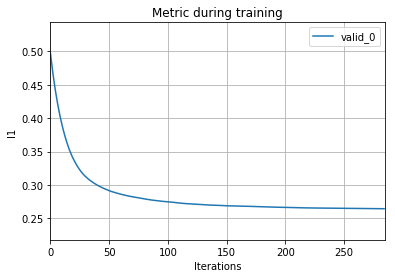

Plotting feature importances...


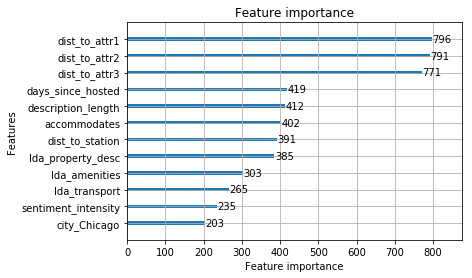

In [76]:
print('Plotting metrics recorded during training...')
ax = lgb.plot_metric(evals_result, metric='l1')
plt.show()

print('Plotting feature importances...')
ax = lgb.plot_importance(gbm, max_num_features=12)
plt.show()


C:\Users\Manu\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'Residuals for the model')

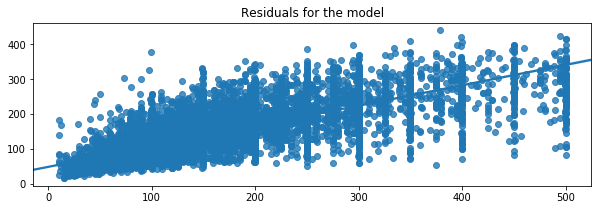

In [77]:
# Plot of Casual and Registered model's residuals:
fig = plt.figure(figsize=(10,3))

sns.regplot(np.exp(y_test),np.exp(y_pred))
plt.title("Residuals for the model")


#### Price

In [ ]:
#Select columns and perform the test train split
train_cols = [
    'accommodates', 
    'days_since_hosted',
    'beds','bathrooms',
    'cleaning_fee',
    'city_Boston', 'city_Chicago', 'city_DC','city_LA', 'city_NYC',
    'room_type_Entire home/apt', 'room_type_Private room',
    'property_type_Apartment','property_type_House', 
    'cancellation_policy_flexible', 'cancellation_policy_moderate','instant_bookable',
    
    # Amenities
    'id', '24-hour check-in', 'Accessible Room', 'Air purifier',
    'Baby Friendly', 'Bathtub', 'Breakfast', 'Cleaning before checkout',
    'Climate Control', 'Coffee maker', 'Comfortable Sleep',
    'Cooking Allowed', 'EV charger', 'Elevator', 'Essentials',
    'Family/kid friendly', 'Fire and Safety Features', 'Free parking',
    'Game console', 'Garden or backyard', 'Gym', 'Hair dryer', 'Hangers',
    'Host greets you', 'Hot water', 'Internet', 'Iron',
    'Laptop friendly workspace', 'Laundry Facility', 'Lockbox',
    'Long term stays allowed', 'Near Water', 'Other', 'Outdoor Lighting',
    'Paid parking', 'Patio or balcony', 'Pet Friendly',
    'Pets live on this property', 'Pool', 'Privacy Centric', 'Refrigerator',
    'Security', 'Single level home', 'Ski in/Ski out', 'Smoking allowed',
    'Suitable for events', 'TV',
    
    #Description
    'description_length','sentiment_intensity', 'lda_attractions', 
    'lda_transport', 'lda_amenities', 'lda_property_desc',
    
    #Distances
    'dist_to_attr1','dist_to_attr2', 'dist_to_attr3', 
    'dist_to_station',
    
    #Previously Excluded
    'bed_type_Real Bed',
    'host_identity_verified',  
    'days_since_hosted',  
    'bed_type_other_bed_type',
    'property_type_other_prop_type',
    'room_type_Shared room',
    'cancellation_policy_strict', 
    'host_has_profile_pic'
]
              
target_col = 'price'

np.random.seed(2018)
train = np.random.choice([True, False], listings.shape[0], replace=True, p=[0.8, 0.2])
listings_lgbm_price_train = listings.iloc[train,:]
listings_lgbm_price_test = listings.iloc[~train,:]

x_train = listings_lgbm_price_train[train_cols].values
x_test = listings_lgbm_price_test[train_cols].values
y_train = listings_lgbm_price_train[target_col].values
y_test = listings_lgbm_price_test[target_col].values


print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

In [ ]:
#Create dataset for lightgbm
lgb_train = lgb.Dataset(x_train, y_train)
lgb_eval = lgb.Dataset(x_test, y_test, reference=lgb_train)

#Config the LGBM model parameters
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

print('Starting training...')
# train

evals_result = {}

gbm = lgb.train(params,
                lgb_train,
                num_boost_round=300,
                valid_sets=lgb_eval,
                early_stopping_rounds=5,
               evals_result=evals_result,
               feature_name=train_cols)

print('Saving model...')
#Save the fit model to a file
gbm.save_model('model.txt')




In [ ]:
# Use the model to predict values
y_pred = gbm.predict(x_train, num_iteration=gbm.best_iteration)

# Calculate the Mean Squared Error using the mean_squared_error function.
print("Training Data")

print("Mean Squared Error : %0.3f" % mean_squared_error(y_train,y_pred))
print("Root Mean Squared Error : %0.3f" % mean_squared_error((y_train),(y_pred))**0.5)
print("SMAPE : %0.3f " % symmetric_mean_absolute_percentage_error((y_train),(y_pred)))

In [ ]:
# Use the model to predict values
y_pred = gbm.predict(x_test, num_iteration=gbm.best_iteration)

# Calculate the Mean Squared Error using the mean_squared_error function.
print("Test Data")

print("Mean Squared Error : %0.3f" % mean_squared_error(y_test,y_pred))
print("Root Mean Squared Error : %0.3f" % mean_squared_error((y_test),(y_pred))**0.5)
print("SMAPE : %0.3f " % symmetric_mean_absolute_percentage_error((y_test),(y_pred)))

In [ ]:
print('Plotting metrics recorded during training...')
ax = lgb.plot_metric(evals_result, metric='l1')
plt.show()

print('Plotting feature importances...')
ax = lgb.plot_importance(gbm, max_num_features=12)
plt.show()


C:\Users\Manu\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'Residuals for the model')

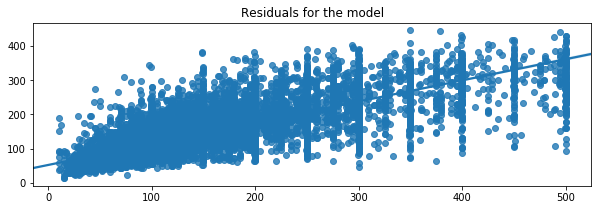

In [696]:
# Plot of Casual and Registered model's residuals:
fig = plt.figure(figsize=(10,3))

sns.regplot((y_test),(y_pred))
plt.title("Residuals for the model")


### Decision tree - Log Price Categories

In [441]:
train_cols = [
    'accommodates', 
    'description_length', 
    'days_since_hosted',
    'city_Boston', 'city_Chicago', 'city_DC','city_LA', 'city_NYC', 
    'room_type_Entire home/apt', 'room_type_Private room',
    'property_type_Apartment','property_type_House', 
    '24-hour check-in', 'Bathtub',
    'Breakfast', 'Cooking Allowed', 'Elevator', 'Essentials',
    'Family/kid friendly', 'Fire and Safety Features', 'Free parking',
    'Gym', 'Hair dryer', 'Hangers', 'Internet', 'Iron',
    'Laptop friendly workspace', 'Laundry Facility', 'Lockbox',
    'Pet Friendly', 'Pets live on this property', 'Pool', 'Privacy Centric',
    'Security', 'Smoking allowed', 'Suitable for events', 'TV',
    'cancellation_policy_flexible', 'cancellation_policy_moderate',
    'bedroom_share','bathroom_share',
    'bed_type_Real Bed',
    'dist_to_attr1','dist_to_attr2', 'dist_to_attr3', 
    'dist_to_station',
    'cleaning_fee'
]
target_col = 'log_price_ep'

x_train = listings_train[train_cols].values
x_test = listings_test[train_cols].values
y_train = listings_train[target_col].values
y_test = listings_test[target_col].values

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
           

(57191, 47) (14277, 47) (57191,) (14277,)


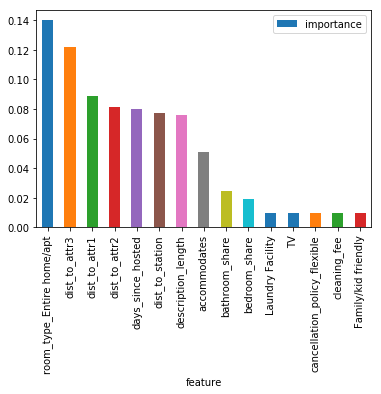

In [442]:
#Make the decision tree
dtree = DecisionTreeClassifier()

dtree.fit(x_train,y_train)

importances = dtree.feature_importances_
feat_names = train_cols
tree_result = pd.DataFrame({'feature': feat_names, 'importance': importances})
tree_result.sort_values(by='importance',ascending=False)[:15].plot(x='feature', y='importance', kind='bar')

In [443]:
#Get Decision Tree mean squared error on test dataset
dtree_y_predict = dtree.predict(x_test)

print("Score: %.3f" % dtree.score(x_test,y_test))

print('Precision: %0.2f \nRecall: %0.2f \nF1 Score: %0.2f' %
      (precision_score(y_test, dtree_y_predict, average='weighted'),
       recall_score(y_test, dtree_y_predict, average='weighted'),
       f1_score(y_test, dtree_y_predict, average='weighted'))
     )

conf_mat_df = pd.DataFrame(data=confusion_matrix(y_test, dtree_y_predict), 
                           #columns=['0', '1', 'p_99_to_100'],
                           #index=['below_93', '93_to_98', '99_to_100']
                          )
conf_mat_df

Score: 0.514
Precision: 0.52 
Recall: 0.51 
F1 Score: 0.52


,0,1,2,3
0,2257,1008,279,100
1,885,1427,898,303
2,292,874,1605,895
3,108,339,963,2044


### Test Train split for Price Classification

In [444]:
train_cols = [
    'accommodates', 
    'description_length', 
    'days_since_hosted',
    'city_Boston', 'city_Chicago', 'city_DC','city_LA', 'city_NYC', 
    'room_type_Entire home/apt', 'room_type_Private room',
    'property_type_Apartment','property_type_House', 
    '24-hour check-in', 'Bathtub',
    'Breakfast', 'Cooking Allowed', 'Elevator', 'Essentials',
    'Family/kid friendly', 'Fire and Safety Features', 'Free parking',
    'Gym', 'Hair dryer', 'Hangers', 'Internet', 'Iron',
    'Laptop friendly workspace', 'Laundry Facility', 'Lockbox',
    'Pet Friendly', 'Pets live on this property', 'Pool', 'Privacy Centric',
    'Security', 'Smoking allowed', 'Suitable for events', 'TV',
    'cancellation_policy_flexible', 'cancellation_policy_moderate',
    'bedroom_share','bathroom_share',
    'bed_type_Real Bed',
    'dist_to_attr1','dist_to_attr2', 'dist_to_attr3', 
    'dist_to_station',
    'cleaning_fee'
]
target_col = 'log_price_categories'

x_train = listings_train[train_cols].values
x_test = listings_test[train_cols].values
y_train = listings_train[target_col].values
y_test = listings_test[target_col].values

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
           

(57191, 47) (14277, 47) (57191,) (14277,)


### Logistic Regression - Log Price Categories Imbalanced

In [445]:
logreg = LogisticRegression()

logreg.fit(x_train,y_train)

#Get Decision Tree mean squared error on test dataset
logreg_y_predict = logreg.predict(x_test)

print("Score: %.3f" % logreg.score(x_test,y_test))

print('Precision: %0.2f \nRecall: %0.2f \nF1 Score: %0.2f' %
      (precision_score(y_test, logreg_y_predict, average='weighted'),
       recall_score(y_test, logreg_y_predict, average='weighted'),
       f1_score(y_test, logreg_y_predict, average='weighted'))
     )

conf_mat_df = pd.DataFrame(data=confusion_matrix(y_test, logreg_y_predict), 
                           #columns=['0', '1', 'p_99_to_100'],
                           #index=['below_93', '93_to_98', '99_to_100']
                          )
conf_mat_df

C:\Users\Manu\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:436: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Manu\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:463: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Score: 0.617
Precision: 0.63 
Recall: 0.62 
F1 Score: 0.60


,0,1,2,3
0,559,1141,100,12
1,264,2452,1059,14
2,95,1224,5380,166
3,9,66,1313,423


In [446]:
print(classification_report(y_test, logreg_y_predict))

              precision    recall  f1-score   support

           1       0.60      0.31      0.41      1812
           2       0.50      0.65      0.57      3789
           3       0.69      0.78      0.73      6865
           4       0.69      0.23      0.35      1811

   micro avg       0.62      0.62      0.62     14277
   macro avg       0.62      0.49      0.51     14277
weighted avg       0.63      0.62      0.60     14277



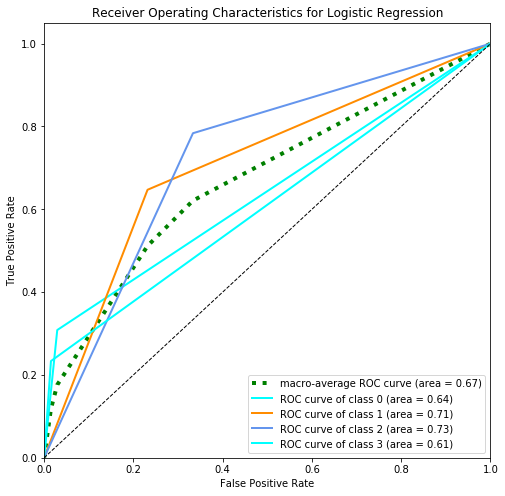

In [449]:
y_test = y_test.ravel()
plot_roc(y_test,logreg_y_predict,'Logistic Regression', n_classes = 4)

### Decision tree - Log Price Categories Imbalanced

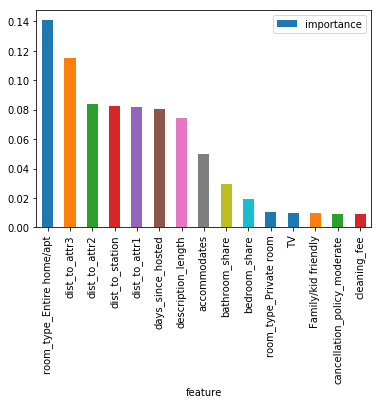

In [450]:
#Make the decision tree
dtree = DecisionTreeClassifier()

dtree.fit(x_train,y_train)

importances = dtree.feature_importances_
feat_names = train_cols
tree_result = pd.DataFrame({'feature': feat_names, 'importance': importances})
tree_result.sort_values(by='importance',ascending=False)[:15].plot(x='feature', y='importance', kind='bar')

In [451]:
#Get Decision Tree mean squared error on test dataset
dtree_y_predict = dtree.predict(x_test)

print("Score: %.3f" % dtree.score(x_test,y_test))

print('Precision: %0.2f \nRecall: %0.2f \nF1 Score: %0.2f' %
      (precision_score(y_test, dtree_y_predict, average='weighted'),
       recall_score(y_test, dtree_y_predict, average='weighted'),
       f1_score(y_test, dtree_y_predict, average='weighted'))
     )

conf_mat_df = pd.DataFrame(data=confusion_matrix(y_test, dtree_y_predict), 
                           #columns=['0', '1', 'p_99_to_100'],
                           #index=['below_93', '93_to_98', '99_to_100']
                          )
conf_mat_df

Score: 0.573
Precision: 0.57 
Recall: 0.57 
F1 Score: 0.57


,0,1,2,3
0,884,671,239,18
1,706,1810,1189,84
2,206,1180,4618,861
3,23,88,826,874


In [452]:
np.sum(conf_mat_df,axis =1)

0    1812
1    3789
2    6865
3    1811
dtype: int64

In [453]:
np.sum(conf_mat_df,axis =0)

0    1819
1    3749
2    6872
3    1837
dtype: int64

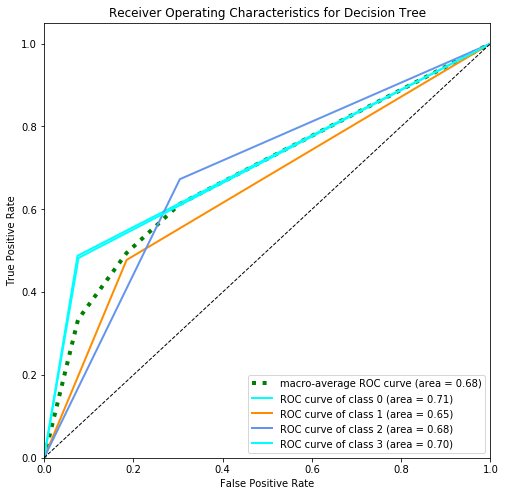

In [455]:
y_test = y_test.ravel()
plot_roc(y_test,dtree_y_predict,'Decision Tree', n_classes = 4)

## Random Forest

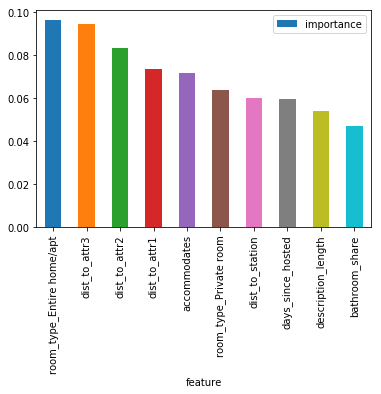

In [456]:
# Random Forest Model
rf = RandomForestClassifier(
    n_estimators=1000, 
    max_depth=30, 
    min_samples_split=10, 
    #class_weight="balanced"
    )

rf.fit(x_train, y_train)
importances = rf.feature_importances_
feat_names = train_cols
tree_result = pd.DataFrame({'feature': feat_names, 'importance': importances})
tree_result.sort_values(by='importance',ascending=False)[:10].plot(x='feature', y='importance', kind='bar')

In [457]:
#Get Random Forest mean squared error on test dataset
rf_y_predict = rf.predict(x_test)

print("Score: %.3f" % rf.score(x_test,y_test))

print('Precision:', precision_score(y_test, rf_y_predict, average='weighted'),
      "Recall:", recall_score(y_test, rf_y_predict, average='weighted'), 
      "F1 Score:", f1_score(y_test, rf_y_predict, average='weighted'))

conf_mat_df = pd.DataFrame(data=confusion_matrix(y_test, rf_y_predict), 
                           #columns=['p_below_93', 'p_93_to_98', 'p_99_to_100'],
                           #index=['below_93', '93_to_98', '99_to_100']
                          )
conf_mat_df

Score: 0.672
Precision: 0.6769624304669224 Recall: 0.6724802129298872 F1 Score: 0.6634099193865881


,0,1,2,3
0,846,868,97,1
1,349,2298,1137,5
2,73,872,5707,213
3,6,45,1010,750


In [458]:
print(classification_report(y_test, rf_y_predict))

              precision    recall  f1-score   support

           1       0.66      0.47      0.55      1812
           2       0.56      0.61      0.58      3789
           3       0.72      0.83      0.77      6865
           4       0.77      0.41      0.54      1811

   micro avg       0.67      0.67      0.67     14277
   macro avg       0.68      0.58      0.61     14277
weighted avg       0.68      0.67      0.66     14277



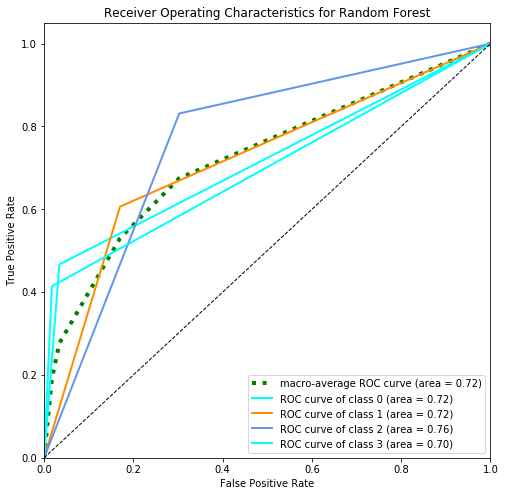

In [459]:
plot_roc(y_test,rf_y_predict,'Random Forest', n_classes = 4)

In [409]:
weighted_classification_err(conf_mat_df.values)

,Labels,Relative classification Error
0,0,0.527042
1,1,0.335973
2,2,0.530347
3,3,0.216969
4,4,0.996310
